In [1]:
from datetime import date, datetime, timedelta
import pymysql
import csv
import os
from pandas import DataFrame
import pandas as pd
from sqlalchemy import create_engine
import mysql.connector
from mysql.connector import errorcode
import glob
import logging
import pandas as pd
from IPython.display import display
pd.options.display.max_columns = None
# for advanced visualizations
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected = True)
#import plotly.figure_factory as ff
# for basic visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import numpy as np

##https://www.kaggle.com/roshansharma/amazon-alexa-reviews


### Configure log information 

In [2]:
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='mylog.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

### Connect to mysql database

In [3]:
try:
    cnn = mysql.connector.connect(
    user='root',
    password='root',
    host='127.0.0.1',
    database='Amazon_review',
    port='3307')
    print ("Amazon_review connection works!")
    cursor = cnn.cursor()
    
except mysql.connector.Error as e:
    if e.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with Username or Password")
    elif e.errno == errorcode.ER_BAD_DB_ERROR:
        print("database Does not exist")
    else:
        print(e)

cursor.execute("show tables;")
results = cursor.fetchall()
logging.info('***********************************************')
logging.info(results)

Amazon_review connection works!


In [4]:
cursor.execute("select product_id, rating,helpful_votes, review_date, title, review from helpful_review;")
amazon_full = cursor.fetchall()
num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]
df = pd.DataFrame(amazon_full, columns=field_names)   

In [5]:
t = 'January 5, 2020'.replace(",", "")
t = t.replace(" ", "-")
print(t)
date_object = datetime.strptime(t, "%B-%d-%Y")
date_object


January-5-2020


datetime.datetime(2020, 1, 5, 0, 0)

### Format the data 

In [6]:
df['rating']=pd.to_numeric(df['rating'])
df['helpful_votes']=pd.to_numeric(df['helpful_votes'])
df['review_date']=df['review_date'].apply(lambda x: datetime.strptime(x.replace(",", "").replace(" ", "-"), "%B-%d-%Y"))
#df['review_date'] = df['review_date'].apply(lambda x: )
df['review_len'] = df['review'].apply(len)
df['title_len'] = df['title'].apply(len)
df.describe(include='all')
# add length of the review
# adding a length column for analyzing the length of the reviews

#display(df.groupby('review_len').describe().sample(10))
#display(df.groupby('title_len').describe().sample(10))


,product_id,rating,helpful_votes,review_date,title,review,review_len,title_len
count,2484,2484.000000,2484.000000,2484,2484,2484,2484.000000,2484.000000
unique,14,NaN,NaN,941,1858,2456,NaN,NaN
top,B07H7Q1DFP,NaN,NaN,2020-01-05 00:00:00,Five Stars,Great,NaN,NaN
freq,746,NaN,NaN,14,120,7,NaN,NaN
first,NaN,NaN,NaN,2008-07-19 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2020-01-25 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,4.489533,0.464573,NaN,NaN,NaN,167.948873,22.015298
std,NaN,1.053680,2.697076,NaN,NaN,NaN,185.553985,15.949697
min,NaN,1.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,4.000000,0.000000,NaN,NaN,NaN,53.000000,11.000000


In [7]:
display(df.review_date.value_counts())
display(pd.DataFrame(df.groupby('rating')['product_id','helpful_votes'].describe(include='all')))


2020-01-05    14
2019-12-12    12
2019-07-09    11
2019-08-23    11
2019-09-18    11
2019-12-14    11
2019-06-24    10
2019-07-22    10
2019-12-17    10
2019-12-26    10
2019-12-16    10
2019-07-17    10
2019-12-21     9
2019-10-08     9
2019-02-24     9
2019-12-18     9
2019-10-04     9
2020-01-11     9
2019-06-19     9
2019-07-24     9
2020-01-03     9
2019-12-27     9
2019-07-08     9
2019-11-18     9
2020-01-12     8
2019-09-17     8
2020-01-21     8
2019-12-15     8
2019-11-14     8
2019-12-31     8
              ..
2017-08-23     1
2018-04-28     1
2017-01-12     1
2019-01-01     1
2017-09-01     1
2018-04-17     1
2017-10-30     1
2018-07-19     1
2017-05-14     1
2016-11-26     1
2017-03-21     1
2018-08-31     1
2018-10-25     1
2017-03-29     1
2017-10-06     1
2018-07-03     1
2018-06-10     1
2018-06-12     1
2016-08-26     1
2018-10-18     1
2017-07-19     1
2015-09-12     1
2015-06-03     1
2018-08-29     1
2017-09-23     1
2018-12-01     1
2016-08-04     1
2017-04-09    

product_id                                                             \
            count unique         top freq mean  std  min  25%  50%  75%  max   
rating                                                                         
1.0           114     11  B01IBUD24G   23  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2.0            82     11  B07H7Q1DFP   19  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3.0           138     11  B01IBUD24G   41  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4.0           290     14  B07H7Q1DFP   73  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
5.0          1860     14  B07H7Q1DFP  601  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

       helpful_votes                                                          \
               count unique top freq      mean       std  min  25%  50%  75%   
rating                                                                         
1.0            114.0    NaN NaN  NaN  0.868421  1.737220  0.0  0.0  0.0  1.0   
2.0             82.0    NaN NaN  NaN  0.365854  1.222345  0.0  0.0  0.0  0.0   
3.0            138.0    NaN NaN  NaN  0.710145  2.327879  0.0  0.0  0.0  0.0   
4.0            290.0    NaN NaN  NaN  0.713793  2.734658  0.0  0.0  0.0  0.0   
5.0           1860.0    NaN NaN  NaN  0.387097  2.806211  0.0  0.0  0.0  0.0   

              
         max  
rating        
1.0      9.0  
2.0     10.0  
3.0     21.0  
4.0     27.0  
5.0     76.0

### Rating Distribution

In [8]:
ratings = df['rating'].value_counts().sort_index(ascending=False)

label_rating = ratings.index
size_rating = ratings.values

colors = ['pink', 'lightblue', 'aqua', 'gold', 'crimson']

rating_piechart = go.Pie(labels = label_rating,
                         values = size_rating,
                         marker = dict(colors = colors),
                         name = 'Alexa', hole = 0.3)

rating_df = [rating_piechart]

layout = go.Layout(
           title = 'Distribution of Ratings for Crutch Pad')

fig = go.Figure(data = rating_df,
                 layout = layout)

py.iplot(fig)
display(ratings)

5.0    1860
4.0     290
3.0     138
2.0      82
1.0     114
Name: rating, dtype: int64

By looking at the above pie chart, we can infer that most of the Ratings are good for 14 Cruch pad products. Around 74.9% people have given this product 5 Star rating on amazon, which is very good. 11.7% people have given these products a 4 Star Rating, which is also good. that means 74.9+11.7 ~ 87% people have given Cruch pad good rating.

A total of 3.3+4.59 ~8% people did not like Cruch pad they purchased.



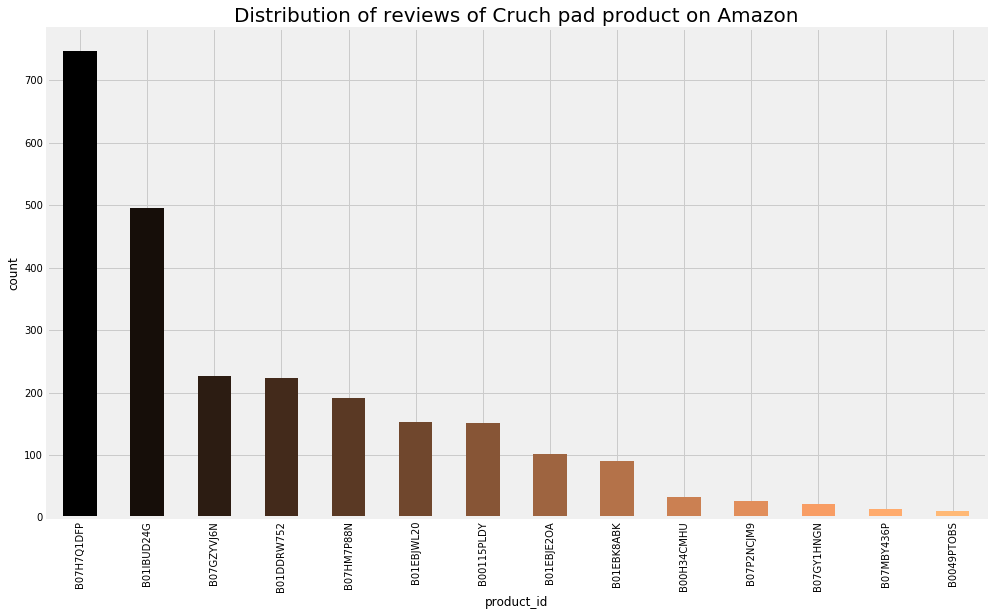

In [9]:
color = plt.cm.copper(np.linspace(0, 1, 15))
df['product_id'].value_counts().plot.bar(color = color, figsize = (15, 9))

plt.title('Distribution of reviews of Cruch pad product on Amazon', fontsize = 20)
plt.xlabel('product_id')
plt.ylabel('count')
plt.show()

The above Bar plot, plots the different cruch pad product with their popularity or no. of counts.

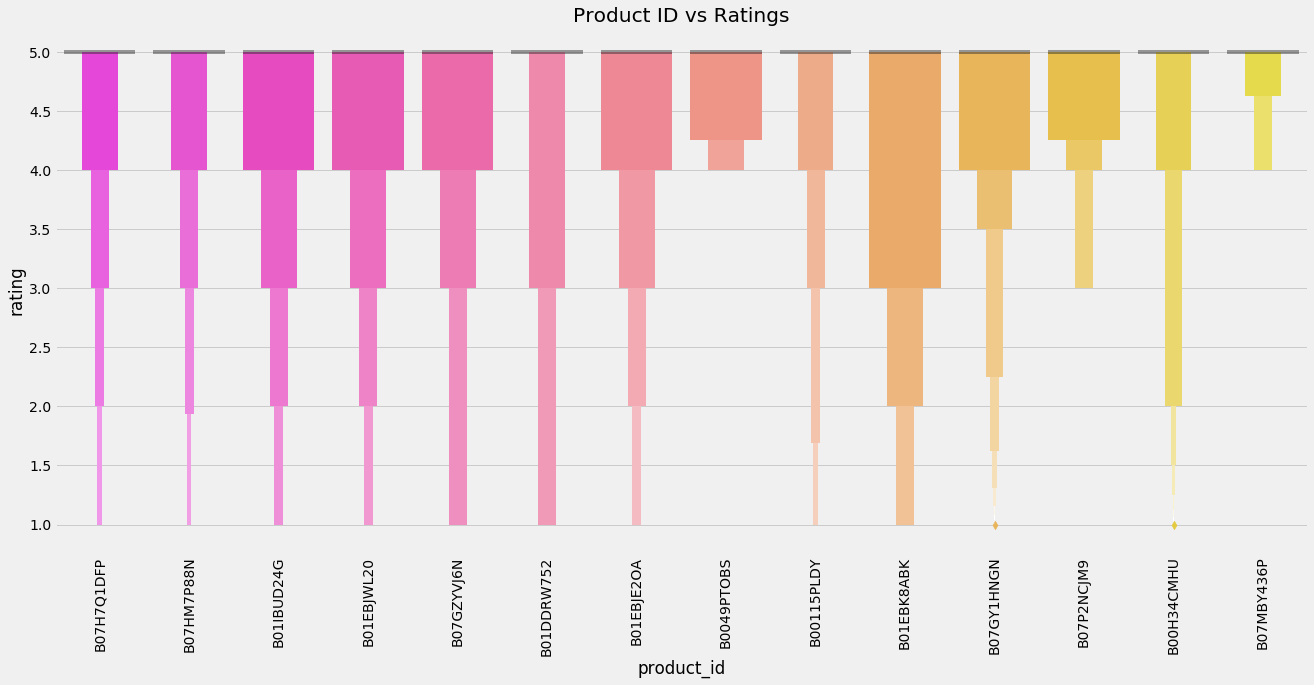

In [26]:
plt.rcParams['figure.figsize'] = (20, 9)
plt.style.use('fivethirtyeight')

sns.boxenplot(df['product_id'], df['rating'], palette = 'spring')
plt.title("Product ID vs Ratings")
plt.xticks(rotation = 90)
plt.show()

The above Box plot, plots the distribution of the rating for each product. 

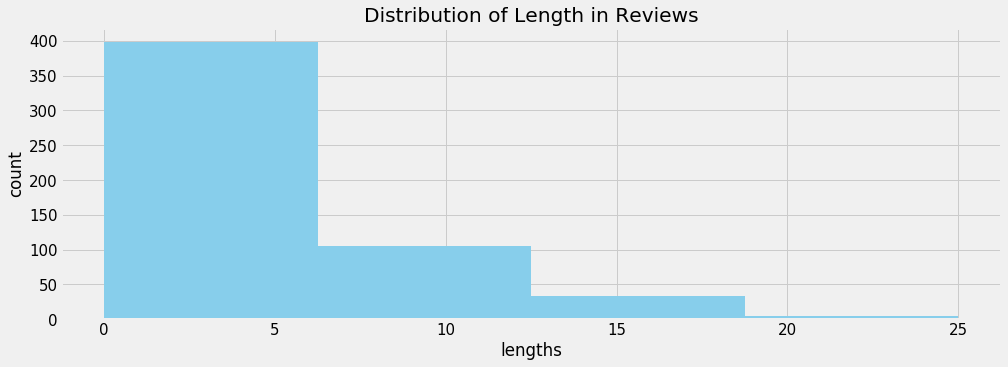

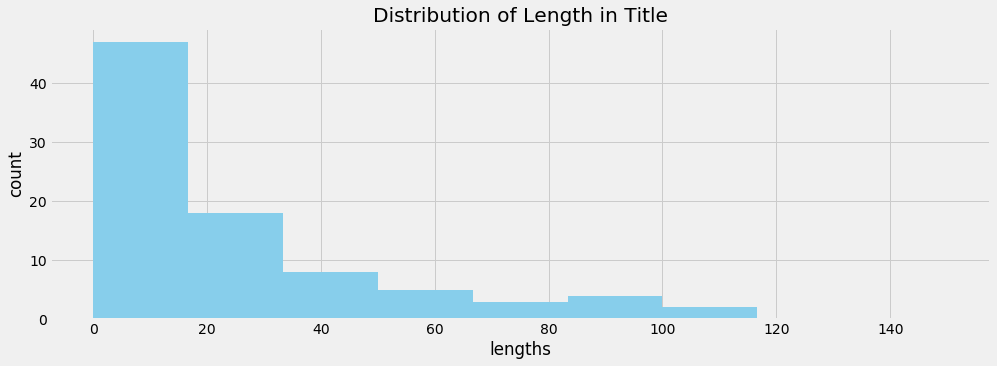

In [27]:
df['review_len'].value_counts().plot.hist(color = 'skyblue', figsize = (15, 5), bins=np.linspace(0, 25, 5))
plt.style.use('fivethirtyeight')
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.title('Distribution of Length in Reviews')
plt.xlabel('lengths')
plt.ylabel('count')
plt.show()
df['title_len'].value_counts().plot.hist(color = 'skyblue', figsize = (15, 5), bins=np.linspace(0, 150, 10))
plt.title('Distribution of Length in Title')
plt.xlabel('lengths')
plt.ylabel('count')
plt.show()

The above Distribution Plot, shows a distribution of Length of the Reviews/title written by the customers. Most of the Reviews are are pretty short. 

In [34]:
#check some reviews by length
df[df['review_len'] == 4]['review']

51      Like
465     Love
1877    Crap
1886    Good
2109    Like
2336    Nice
Name: review, dtype: object

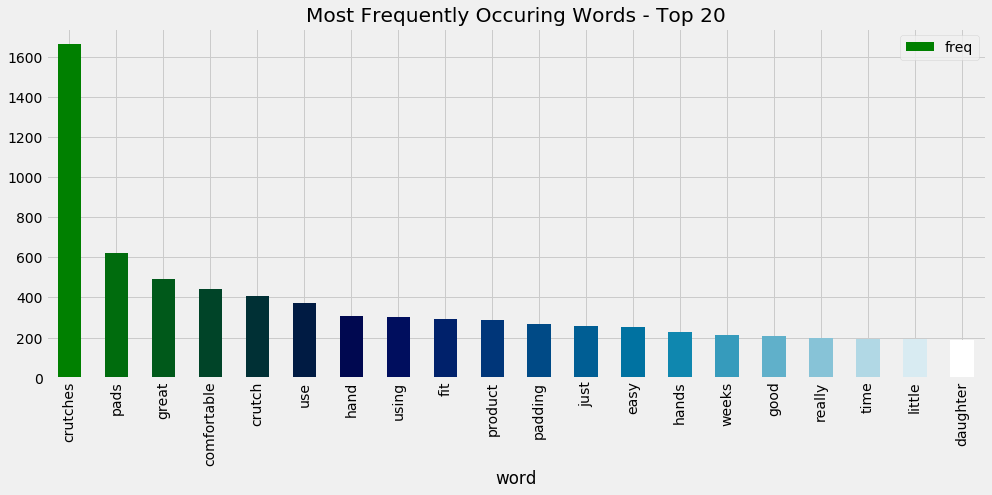

In [28]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.review)
sum_words = words.sum(axis=0)


words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

plt.style.use('fivethirtyeight')
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Occuring Words - Top 20")
plt.show()

The Above Bar plot gives us a rough idea about what customers mentioned most in their review. 

We can see that love is the most frequent word in the word suggesting that most of the people absolutely love alexa. Other frequent words that suggest alexa is doing well are amazing, like, great, works etc.